## Try to check whether the model perform properly by reproducing ORegan2022 paper Fig. 15, i.e., discharge at 0.5C, 1C, 2C at 25degC then rest, in their work, the results for relaxation are way off!

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

In [3]:
model = pb.lithium_ion.DFN(
    options={
    "SEI": "interstitial-diffusion limited",
    "SEI on cracks": "true",
    "lithium plating": "partially reversible",
    "lithium plating porosity change":"true",
    "particle mechanics": ("swelling and cracking", "swelling only"),
    "loss of active material": "stress-driven",
    "contact resistance": "true",
    "open-circuit potential": "current sigmoid",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    "thermal": "lumped",
    }, )


param = pb.ParameterValues("OKane2023")
para_dict = {
    "Contact resistance [Ohm]": 0.0115,
    'Inner SEI lithium interstitial diffusivity [m2.s-1]':9.81e-18, 
    'Dead lithium decay constant [s-1]':1e-7,
    'Lithium plating kinetic rate constant [m.s-1]':1e-10,
    'Negative electrode LAM constant proportional term [s-1]':2.84e-9,
    'Positive electrode LAM constant proportional term [s-1]':2.98e-18,
    'Negative electrode cracking rate':5.29e-25,
    'Outer SEI partial molar volume [m3.mol-1]':5.22e-5,
    'Inner SEI partial molar volume [m3.mol-1]':5.22e-5,
    "SEI growth activation energy [J.mol-1]":1e4,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    "Negative electrode diffusivity activation energy [J.mol-1]":1.7e4,
    "Positive electrode diffusivity activation energy [J.mol-1]":1.2e4,
    'Total heat transfer coefficient [W.m-2.K-1]':20,
}
for key, value in para_dict.items():
    param.update({key: value})
param.update({'Ambient temperature [K]': 25+273.15})

V_max = 4.2;        V_min = 2.5; Update_Cycles = 1

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 20,  # positive particle
}


In [5]:
# Run BOL, different C rate discharge then rest
C_rates = [0.5,1,2]
Sol = []
for C_rate in C_rates:
    exp_RPT_text = [ (
        # refill
        f"Hold at {V_max}V until C/100",
        # 0.1C cycle 
        f"Discharge at {C_rate}C until {V_min} V",  
        "Rest for 1.5 hours",  
        ) ] 
    Experiment_RPT   = pb.Experiment( exp_RPT_text * 1  )
    sim = pb.Simulation(
        model, 
        experiment=Experiment_RPT,
        parameter_values=param,
        solver=pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts, )
    sol = sim.solve(calc_esoh=False,)
    Sol.append(sol)

At t = 261.626 and h = 2.26439e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 65.2453 and h = 9.40765e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 65.2448 and h = 8.0729e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 65.2445 and h = 2.78375e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 505.857 and h = 3.84396e-12, the corrector convergence failed repeatedly or with |h| = hmin.


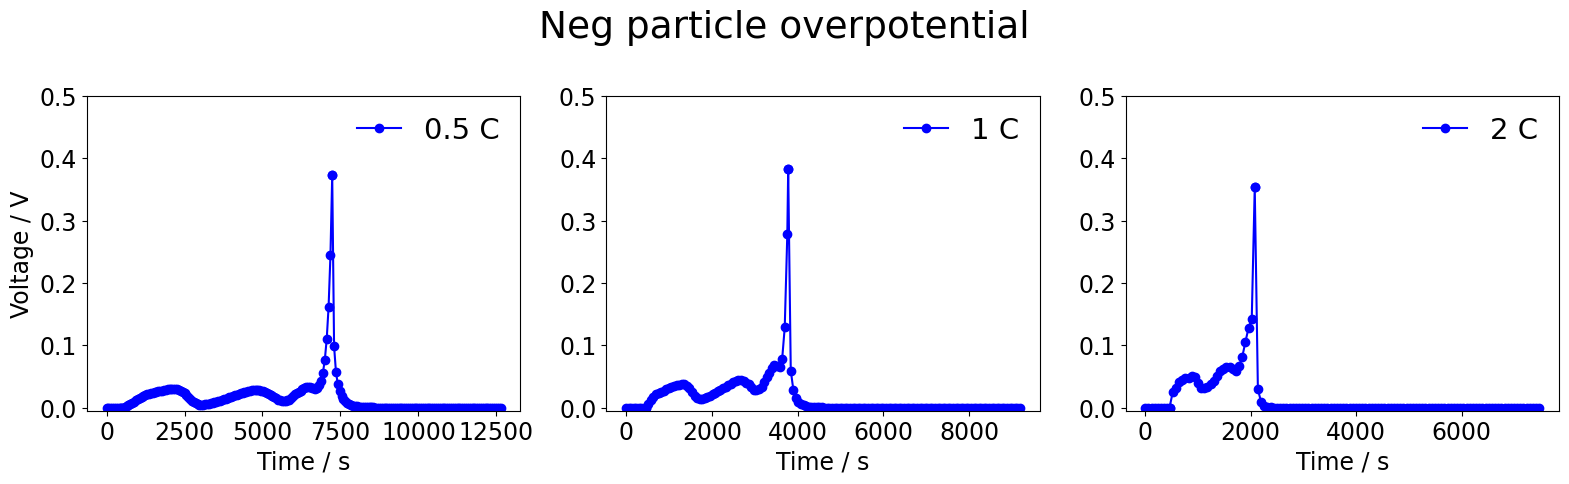

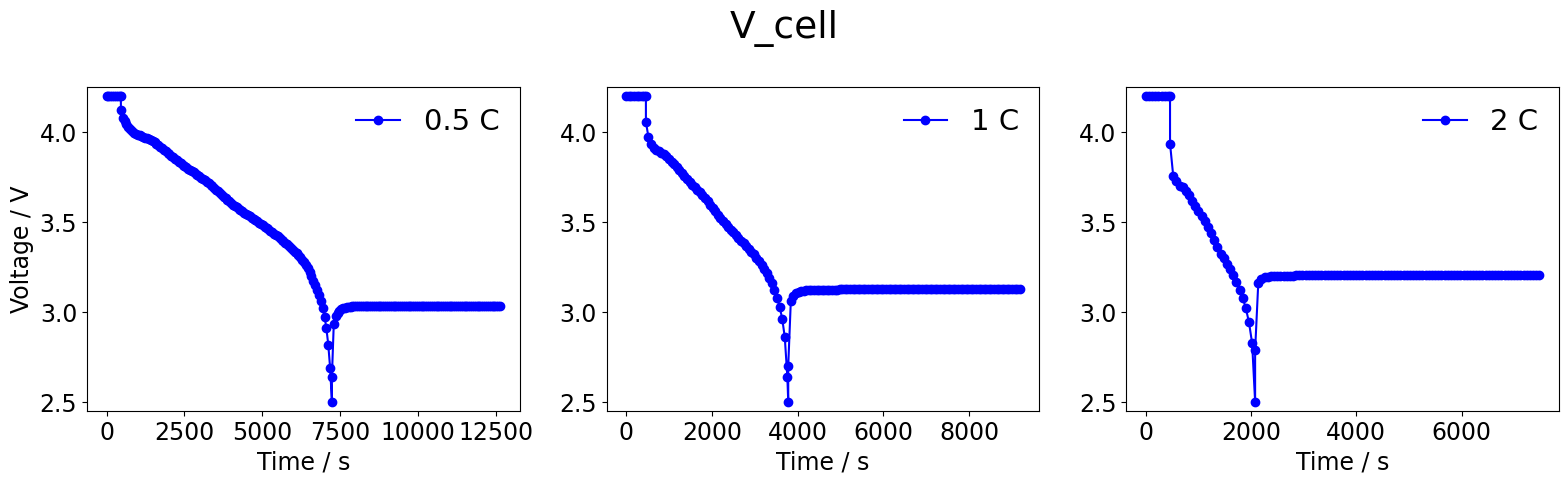

In [12]:
def Plot_compare_sols(Sol,C_rates,Fig_title,key,ylim):
    fig, Axs = plt.subplots(1,3, figsize=(16,5),tight_layout=True)
    for i in range(3):
        axs = Axs[i]
        axs.plot(
            Sol[i].cycles[0]["Time [s]"].entries,
            Sol[i].cycles[0][key].entries, 
            color='b',   linestyle='-',marker = 'o',
            label=f"{C_rates[i]} C")
        axs.set_xlabel("Time / s")
        axs.legend(prop={'family':'DejaVu Sans','size':fs+4},
            frameon=False,markerscale=1,borderpad=0.2,
            handlelength=1.5,columnspacing=1)
        axs.set_ylim(ylim)
    #Axs[1].set_xlim(0,2.5) 
    #Axs[2].set_xlim(0,1.5)
    
    
    #axs.set_ylim(2.45,3.7)
    Axs[0].set_ylabel("Voltage / V")
    #Axs[0].set_title("Big picture")
    #Axs[1].set_title("Zoom in")
    #Axs[2].set_title("Further zoom in")
    fig.suptitle(Fig_title, fontsize=fs+10)
    #Axs[1].set_ylim(2.45,3.6)
    #Axs[2].set_ylim(2.45,3.6)
    return 

Plot_compare_sols(Sol,C_rates,"Neg particle overpotential"    ,
    "Battery negative particle concentration overpotential [V]",[-0.005,0.5])
Plot_compare_sols(Sol,C_rates,"V_cell"    ,
    "Terminal voltage [V]",[2.45,4.25] )
